# Импорт библиотек

In [67]:

import numpy as np
import pandas as pd 

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import squarify
import plotly.express as px

# импортируем библиотеки для оценки тональности отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

#импортируем библиотеки для кодирования признаков
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mazur\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Загрузка и обработка данных

In [68]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv') # самбмишн


In [69]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
!pip freeze > requirements.txt

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [71]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [72]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [73]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [74]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\mazur\AppData\Local\Temp\ipykernel_4508\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В полученном датасете 515738 значений, которые будут использованы для того, чтобы построить предсказательную модель. Теперь можно заняться заполнением пропусков и очисткой данных

### Удалим все дубликаты из данных

In [76]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
df_train = df_train.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df_train.shape))

Количество дубликатов: 336
Размер таблицы после удаления дубликатов: (386496, 18)


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Проверим наличие пустых значений

In [78]:
# Проверка наличия пропущенных значений, повторно проверим
print(data.isnull().sum())

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64


В данных большинство признаков не имеют пропущенных значений, что указывает на хорошее качество данных. Однако, есть пропущенные значения в столбцах lat (широта отеля) и lng (долгота отеля), где отсутствуют данные для 3268 записей. Это может указывать на то, что для некоторых отелей не была указана географическая информация.

Проверим названия отелей, у которых не указаны широта и долгота:

In [79]:
print('Число отелей, без информации о широте и долготе - {}'.format(data[data['lng'].isnull() | data['lat'].isnull()]['hotel_name'].nunique()))

Число отелей, без информации о широте и долготе - 17


Эти данные можно ввести вручную.

In [80]:
# Группируем по отелям, чтобы посмотреть у каких отелей отсутствуют геоданные
hotels_without_coor = data[data.lng.isna() & data.lat.isna()].groupby(by = ['hotel_address','hotel_name']).\
  count().iloc[:,0].to_frame().reset_index()
display(f'Геоданные отсутствуют у {hotels_without_coor.shape[0]} отелей:')
hotels_without_coor

'Геоданные отсутствуют у 17 отелей:'

,hotel_address,hotel_name,additional_number_of_scoring
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55
2,4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290
3,Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146
4,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,City Hotel Deutschmeister,93
5,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Hotel Park Villa,61
6,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,Fleming s Selection Hotel Wien City,658
7,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,Cordial Theaterhotel Wien,57
8,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,Hotel Daniel Vienna,245
9,Paragonstra e 1 11 Simmering 1110 Vienna Austria,Roomz Vienna,49


In [81]:
hotels_without_coor[['lat','lng']] = 0
hotels_without_coor.loc[0,['lat','lng']] = ['48.8399957','2.3070823']
hotels_without_coor.loc[1,['lat','lng']] = ['48.8889127','2.3309643']
hotels_without_coor.loc[2,['lat','lng']] = ['48.8753208','2.3212033']
hotels_without_coor.loc[3,['lat','lng']] = ['41.391552','2.1757053']
hotels_without_coor.loc[4,['lat','lng']] = ['48.2208555','16.3644228']
hotels_without_coor.loc[5,['lat','lng']] = ['48.233592','16.3434781']
hotels_without_coor.loc[6,['lat','lng']] = ['48.2094054','16.3512565']
hotels_without_coor.loc[7,['lat','lng']] = ['48.2095525','16.3492746']
hotels_without_coor.loc[8,['lat','lng']] = ['48.1888183','16.381591']
hotels_without_coor.loc[9,['lat','lng']] = ['48.1868142','16.418528']
hotels_without_coor.loc[10,['lat','lng']] = ['41.3749946','2.1102353']
hotels_without_coor.loc[11,['lat','lng']] = ['48.219573','16.2834034']
hotels_without_coor.loc[12,['lat','lng']] = ['41.3832425','2.1607609']
hotels_without_coor.loc[13,['lat','lng']] = ['48.2458909','16.3397395']
hotels_without_coor.loc[14,['lat','lng']] = ['48.2135906','16.3777195']
hotels_without_coor.loc[15,['lat','lng']] = ['48.2168032','16.357717']
hotels_without_coor.loc[16,['lat','lng']] = ['48.220414','16.3536299']

# Установим адрес как индекс, для последующего применения метода map
hotels_without_coor.set_index('hotel_address', inplace=True)

In [82]:
def add_missing_coors(address, data_dict):
    """
    Функция для заполнения пропусков в геоданных.
    Использует адрес для поиска широты (lat) и долготы (lng) в предоставленном DataFrame.
    Адрес в DataFrame является индексом.

    Args:
        address (str): строка с адресом отеля.
        data_dict (pd.DataFrame): DataFrame с lng, lat в качестве признаков и адресом в качестве индекса.

    Returns:
        pd.Series: возвращает Series с широтой и долготой.
    """
    if address in data_dict.index:
        return pd.Series([data_dict.loc[address, 'lat'], data_dict.loc[address, 'lng']], index=['lat', 'lng'])

In [83]:
# Преобразуем записи, у которых есть пропуски по геоданным, и заполняем их данными в соотвествии с указанными выше геокоординатами
data.loc[data[(data.lat.isna() | data.lng.isna())].index,['lat','lng']] = \
data[data.lat.isna() | data.lng.isna()].loc[:].\
  apply(lambda x: add_missing_coors(x.hotel_address, hotels_without_coor), axis = 1)

In [84]:
# Отделим число от слова "день" и переведем в int
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])
data['days_since_review'] = data['days_since_review'].astype('int64')

In [85]:
# Приведем дату к правильному формату
data['review_date'] = pd.to_datetime(data['review_date'])

# Разделим строковое значение даты на 3 числовых значения - года, месяца и дня публикации отзыва соответственно
data['year_of_review'], data['month_of_review'],  data['day_of_review'] = pd.to_datetime(data['review_date']).dt.year, \
pd.to_datetime(data['review_date']).dt.month, pd.to_datetime(data['review_date']).dt.day

In [86]:
# Преобразуем строку с тегами в список
data['tags_list'] = data['tags'].apply(lambda x: x.strip('[]').split(', '))

# Распаковываем список тегов в отдельные строки
tags_expanded = data['tags_list'].explode()

# Анализ данных

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Признак 'hotel_address' 

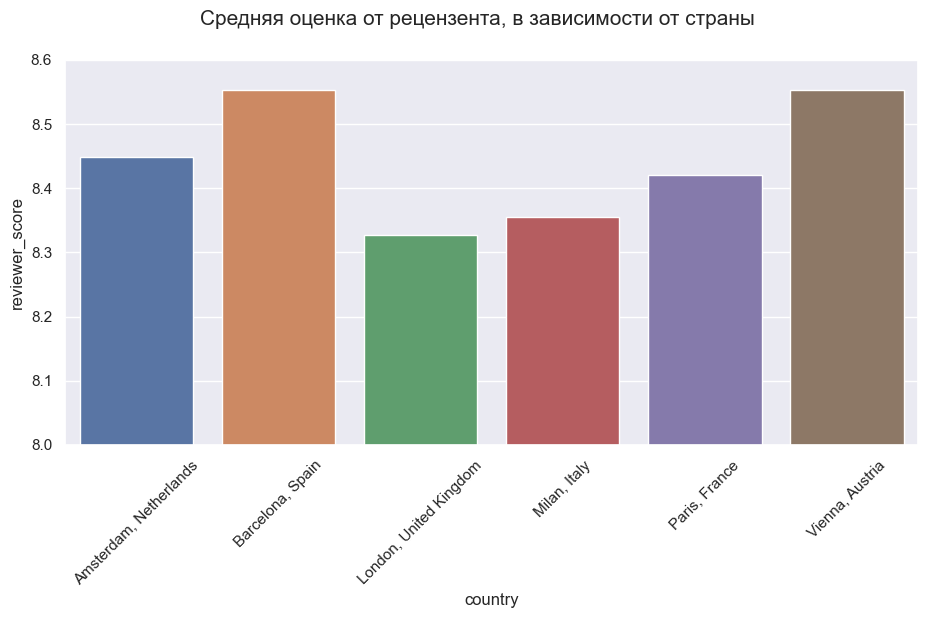

In [88]:
def address(address):
    """Функция выведения города и страны нахождения отеля"""
    if 'Kingdom' in address:
        return address.split()[-5]+', United Kingdom'
    else:
        city = address.split()[-2::]
        return ', '.join(city)

# Создаем признак страны и города нахождения отеля.
data['country'] = data['hotel_address'].apply(address)


# Создадим таблицу с необходимыми данными для визуализации.
reviewer_score_country = data[data['sample']==1].pivot_table(
    values='reviewer_score', 
    index='country', 
    aggfunc='mean')

# Создаем столбчатую диаграмму.
plt.figure(figsize=(11, 5))
barplot_m = sns.barplot(
    data = reviewer_score_country,
    x = reviewer_score_country.index, 
    y = 'reviewer_score')

# Корректируем диаграмму для лучшей наглядности.
plt.suptitle('Средняя оценка от рецензента, в зависимости от страны',  
    fontsize=15)
plt.xticks(rotation= 45)
plt.ylim(8, 8.6);

London, United Kingdom    262301
Barcelona, Spain           60149
Paris, France              59928
Amsterdam, Netherlands     57214
Vienna, Austria            38939
Milan, Italy               37207
Name: country, dtype: int64


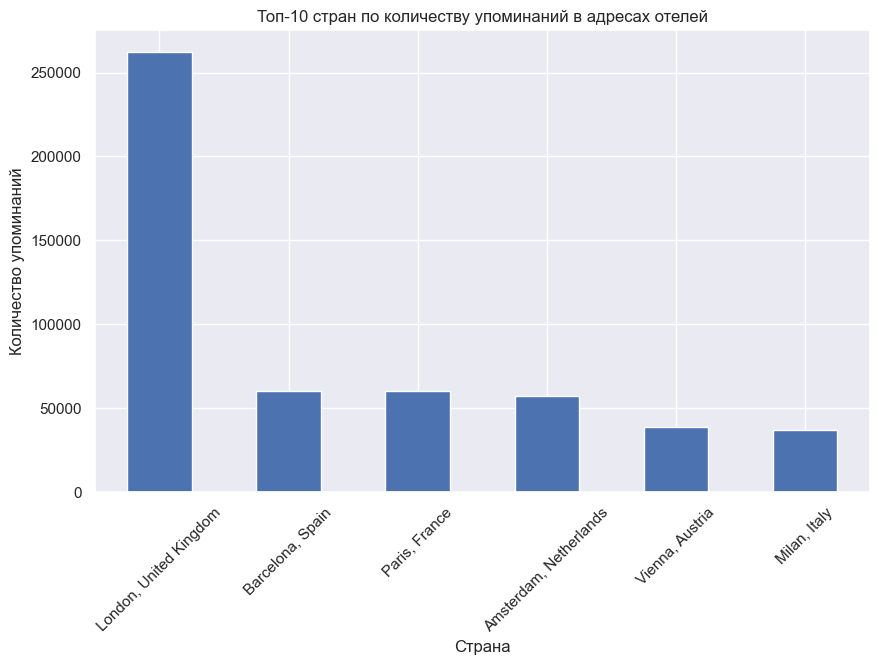

In [89]:
# Подсчет количества упоминаний каждой страны
country_counts = data['country'].value_counts().head(10)

# Вывод топ-10 стран
print(country_counts)

# Визуализация топ-10 стран
country_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Топ-10 стран по количеству упоминаний в адресах отелей')
plt.xlabel('Страна')
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=45)
plt.show()

Данные по адресам отеллей показали, что всего представлено 6 стран из них Лондон является наиболее популярным в выборке. Данные по Британии больще чем все остальные. 

## Признак 'hotel_name' 

Общее количество уникальных отелей: 1492
Топ-10 самых часто упоминаемых отелей:
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
Grand Royale London Hyde Park                        2958
Holiday Inn London Kensington                        2768
Hilton London Metropole                              2628
Millennium Gloucester Hotel London                   2565
Intercontinental London The O2                       2551
Name: hotel_name, dtype: int64


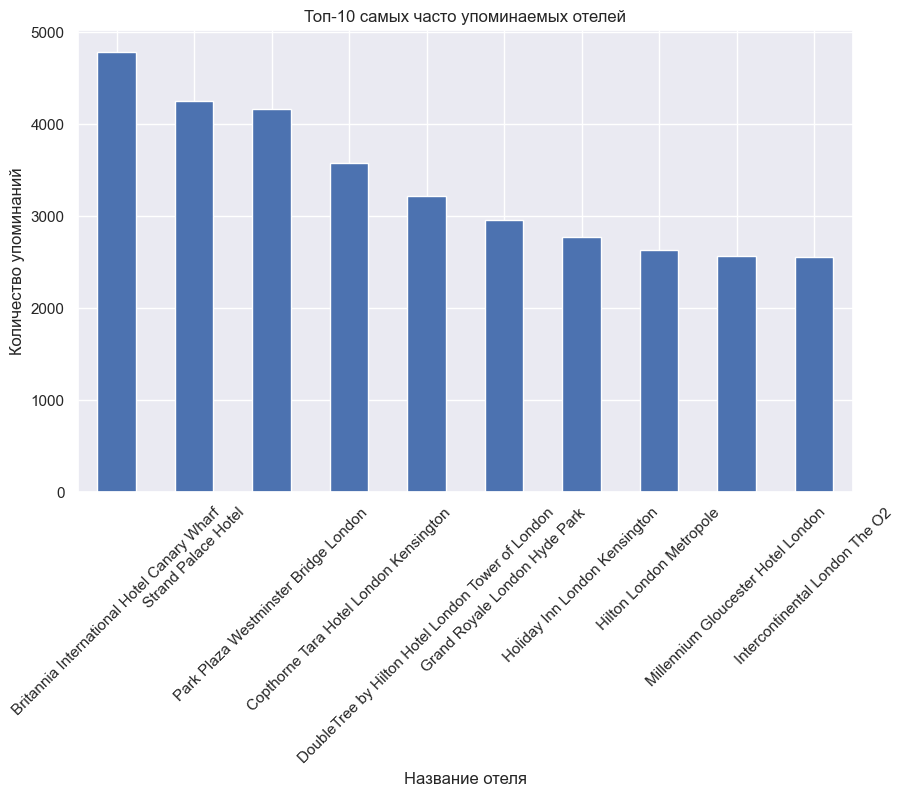

In [90]:
# Получение общего количества уникальных отелей
unique_hotels = data['hotel_name'].nunique()
print(f'Общее количество уникальных отелей: {unique_hotels}')

# Получение топ-10 самых часто упоминаемых отелей
top_hotels = data['hotel_name'].value_counts().head(10)
print('Топ-10 самых часто упоминаемых отелей:')
print(top_hotels)

# Визуализация топ-10 самых часто упоминаемых отелей
top_hotels.plot(kind='bar', figsize=(10, 6))
plt.title('Топ-10 самых часто упоминаемых отелей')
plt.xlabel('Название отеля')
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=45)
plt.show()

В подтверждение к предидузему признаку также наиболее полпулярными отзывами оказались именно лондонские отели.

## Признак 'reviewer_nationality' 

In [91]:
data['reviewer_nationality'].nunique()

227

In [92]:
# Подсчет количества отзывов по каждой национальности
nationality_counts = data['reviewer_nationality'].value_counts()
print(f'Количество отзывов по национальности:\n{nationality_counts}')

Количество отзывов по национальности:
 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64


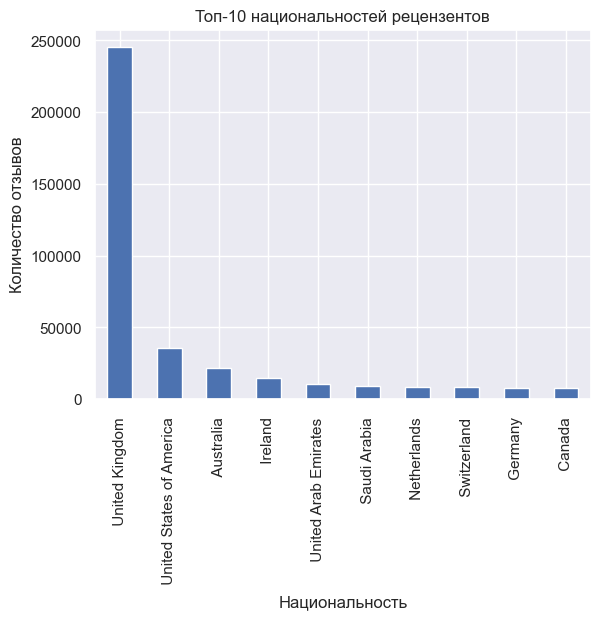

In [93]:
# Ограничим вывод для лучшей визуализации
top_nationalities = nationality_counts.head(10)
top_nationalities.plot(kind='bar')
plt.title('Топ-10 национальностей рецензентов')
plt.xlabel('Национальность')
plt.ylabel('Количество отзывов')
plt.show()

можно сделать следующие выводы:
* Ведущая национальность: Великобритания значительно опережает другие страны по количеству рецензентов, что может указывать на высокую активность британских пользователей на сайте Booking.
* Следующие позиции: Соединенные Штаты Америки занимают второе место, но их количество рецензентов значительно меньше по сравнению с Великобританией.
* Другие страны: Австрия, Ирландия, Объединенные Арабские Эмираты, Саудовская Аравия, Нидерланды, Швейцария, Германия и Канада имеют относительно низкое количество рецензентов.

In [94]:
# Находим топ-4 наиболее встречающихся национальности
top_nationalities = data['reviewer_nationality'].value_counts().head(4).index

# Функция для категоризации национальностей
def categorize_nationality(nat):
    if nat in top_nationalities:
        return nat
    else:
        return 'Others'

# Применяем функцию к столбцу 'reviewer_nationality'
data['nationality_category'] = data['reviewer_nationality'].apply(categorize_nationality)

# Проверяем результат
print(data['nationality_category'].value_counts())

 United Kingdom               245246
Others                        198542
 United States of America      35437
 Australia                     21686
 Ireland                       14827
Name: nationality_category, dtype: int64


## Признак 'review_date ' 

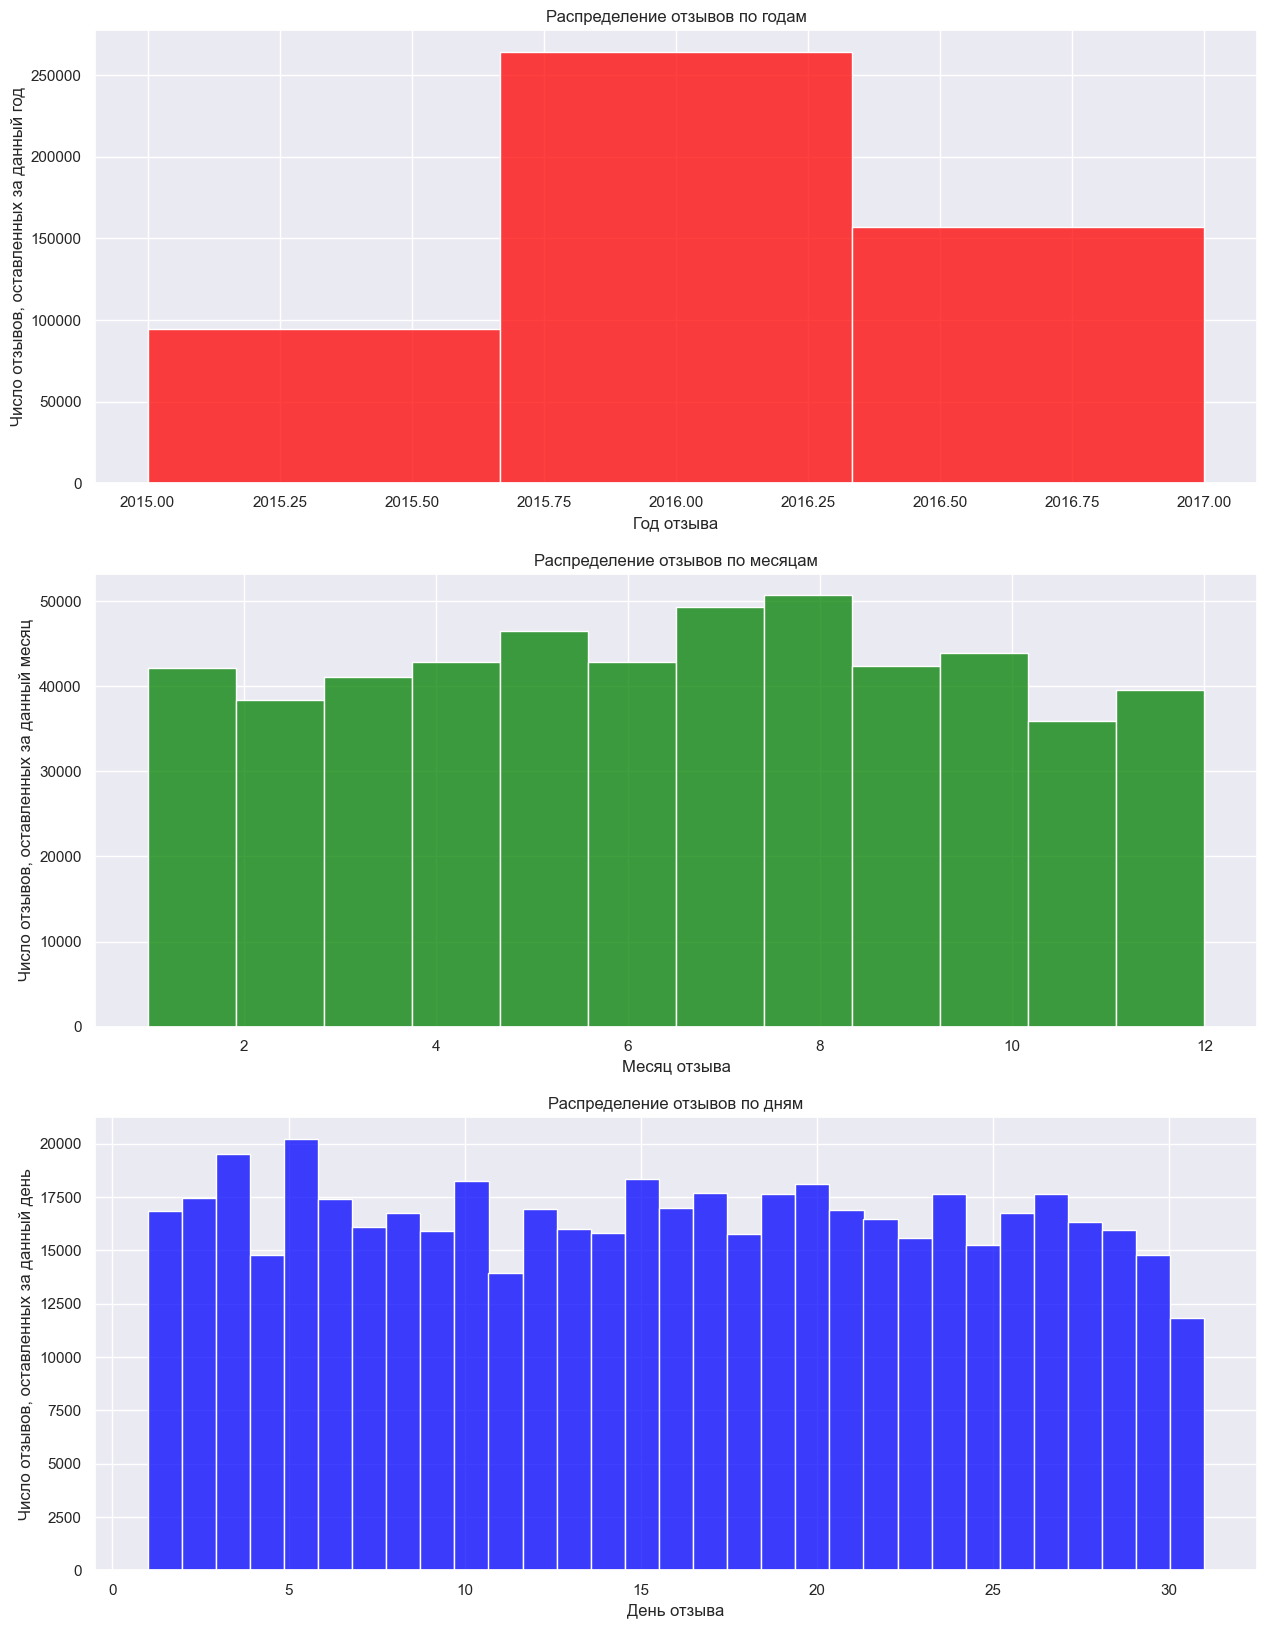

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

histplot1 = sns.histplot(x=data['year_of_review'], bins=3, ax=axes[0], color='red');
histplot1.set_xlabel('Год отзыва');
histplot1.set_ylabel('Число отзывов, оставленных за данный год');
histplot1.set_title('Распределение отзывов по годам');

histplot2 = sns.histplot(data['month_of_review'], bins=12, ax=axes[1], color='green');
histplot2.set_xlabel('Месяц отзыва');
histplot2.set_ylabel('Число отзывов, оставленных за данный месяц');
histplot2.set_title('Распределение отзывов по месяцам');

histplot3 = sns.histplot(data['day_of_review'], bins=31, ax=axes[2], color='blue');
histplot3.set_xlabel('День отзыва');
histplot3.set_ylabel('Число отзывов, оставленных за данный день');
histplot3.set_title('Распределение отзывов по дням');


Из анализа дат отзывов можно сделать следующие наблюдения:

* Анализируя годы, можно заметить, что пик активности отзывов пришелся на 2016 год, за ним следует 2017 год, в то время как 2015 год демонстрирует самый низкий уровень отзывов.

* Месячная статистика отражает явную корреляцию с периодами отпусков. Большинство отзывов было опубликовано в мае, июле и августе, а также в октябре, что соответствует бархатному сезону в теплых странах. Это объясняется тем, что в эти месяцы люди активнее путешествуют, что приводит к увеличению числа гостей в отелях и, соответственно, к увеличению количества отзывов.

* Дневная статистика показывает довольно равное распределение по дням и затруднительно показать какую нибуль связь отзывов по дням.

Исходя из первичной визуализации, можно предположить, что дата публикации играет значимую роль в оценке отелей, но для полного понимания ее влияния потребуется более глубокий разведывательный анализ данных.

In [96]:
data.drop('review_date', axis=1, inplace=True)

## Признак 'tags' 

In [97]:
tags_expanded.value_counts().head(30)

' Leisure trip '                      417778
' Submitted from a mobile device '    307640
' Couple '                            252294
' Stayed 1 night '                    193645
' Stayed 2 nights '                   133937
' Solo traveler '                     108545
' Stayed 3 nights '                    95821
' Business trip '                      82939
' Group '                              65392
' Family with young children '         61015
' Stayed 4 nights '                    47817
' Double Room '                        35207
' Standard Double Room '               32248
' Superior Double Room '               31393
' Family with older children '         26349
' Deluxe Double Room '                 24823
' Double or Twin Room '                22393
' Stayed 5 nights '                    20845
' Standard Double or Twin Room '       17483
' Classic Double Room '                16989
' Superior Double or Twin Room '       13570
' 2 rooms '                            12393
' Stayed 6

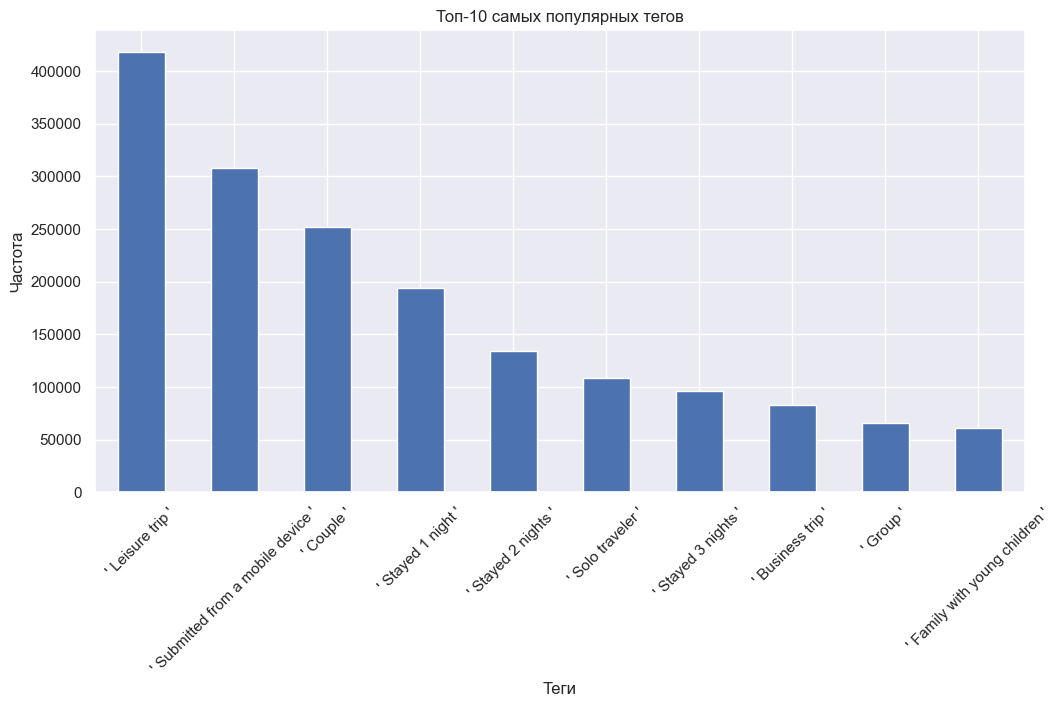

In [98]:
# Визуализация топ-10 самых популярных тегов
plt.figure(figsize=(12, 6))
tags_expanded.value_counts().head(10).plot(kind='bar')
plt.title('Топ-10 самых популярных тегов')
plt.xlabel('Теги')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

Это довольно интересный признак. Из него можно получить информацию, на сколько ночей остались гости, какой тип поездки был, какой группой было совершено путешествие. 

In [99]:
data['trip'] = data['tags_list'].apply(lambda tags: next((tag for tag in tags if 'trip' in tag), 'Unknown trip'))

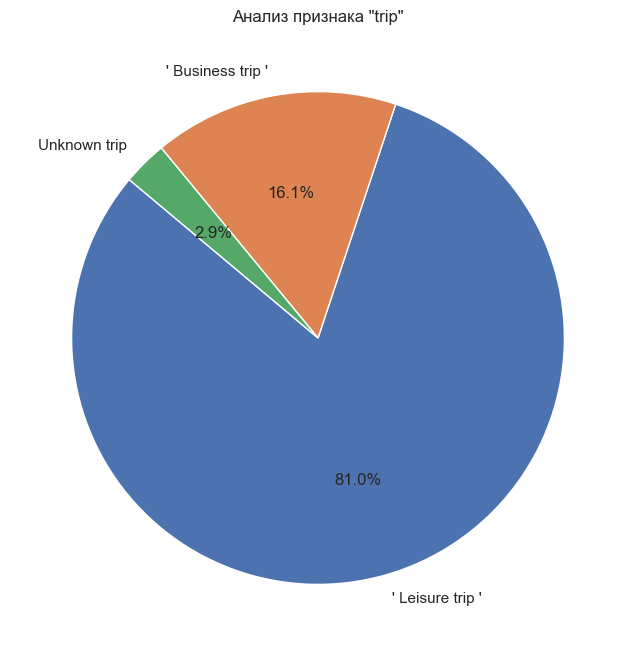

In [100]:
# Создание круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(data['trip'].value_counts(), labels=data['trip'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Анализ признака "trip"')
plt.show()

Отдыхающие: Основная часть отзывов (81.0%) относится к категории “Отдых”, что подчеркивает, что большинство путешествий совершается в целях отдыха.
Деловые поездки: Значительно меньшая часть отзывов (16.1%) приходится на “Деловые поездки”, что может указывать на то, что платформа менее популярна среди деловых путешественников.
Неизвестные поездки: Небольшой процент отзывов (2.9%) не имеет конкретной категории и классифицируется как “Неизвестные поездки”.

Данные теги содержат много данных, которые можно доисследовать. Однако это довольно времязатратно и требует дополнительного ресурса.

## Признак 'days_since_review' 

In [101]:
# Статистическое описание признака 'days_since_review'
description = data['days_since_review'].describe()
print(description)

count    515738.000000
mean        354.441932
std         208.928124
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64


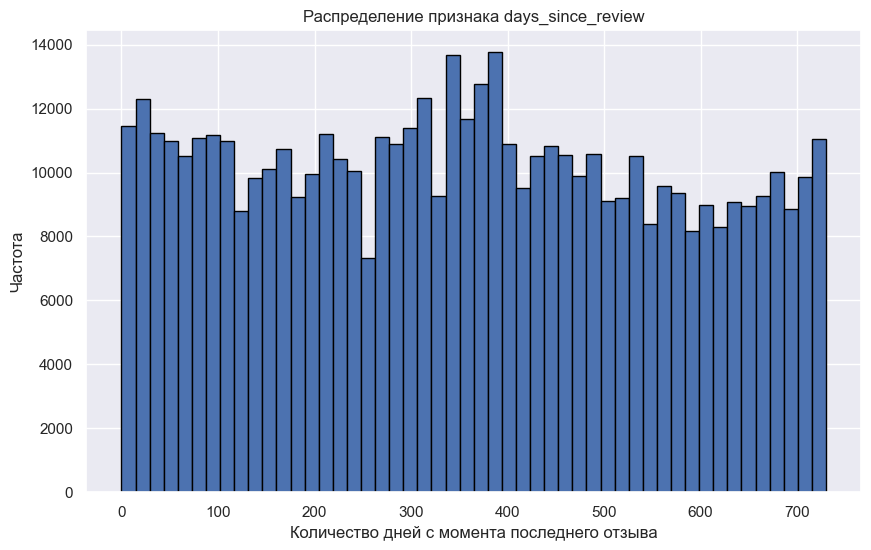

In [102]:
# Визуализация распределения признака 'days_since_review'
plt.figure(figsize=(10, 6))
data['days_since_review'].hist(bins=50, edgecolor='black')
plt.title('Распределение признака days_since_review')
plt.xlabel('Количество дней с момента последнего отзыва')
plt.ylabel('Частота')
plt.show()

Исходя из визуализации данных о количестве дней с момента последнего отзыва, можно сделать следующие выводы:

* Распределение: Большинство отзывов были оставлены относительно недавно, что указывает на активное использование платформы для отзывов.
* Пиковые периоды: Наибольшее количество отзывов приходится на период до 100 дней с момента последнего отзыва, что может свидетельствовать о высокой частоте посещений отелей.
* Долгосрочные отзывы: Существует также меньшее количество отзывов, которые были оставлены более 700 дней назад, что может указывать на долгосрочное взаимодействие клиентов с отелями

## Признак 'total_number_of_reviews_reviewer_has_given'  

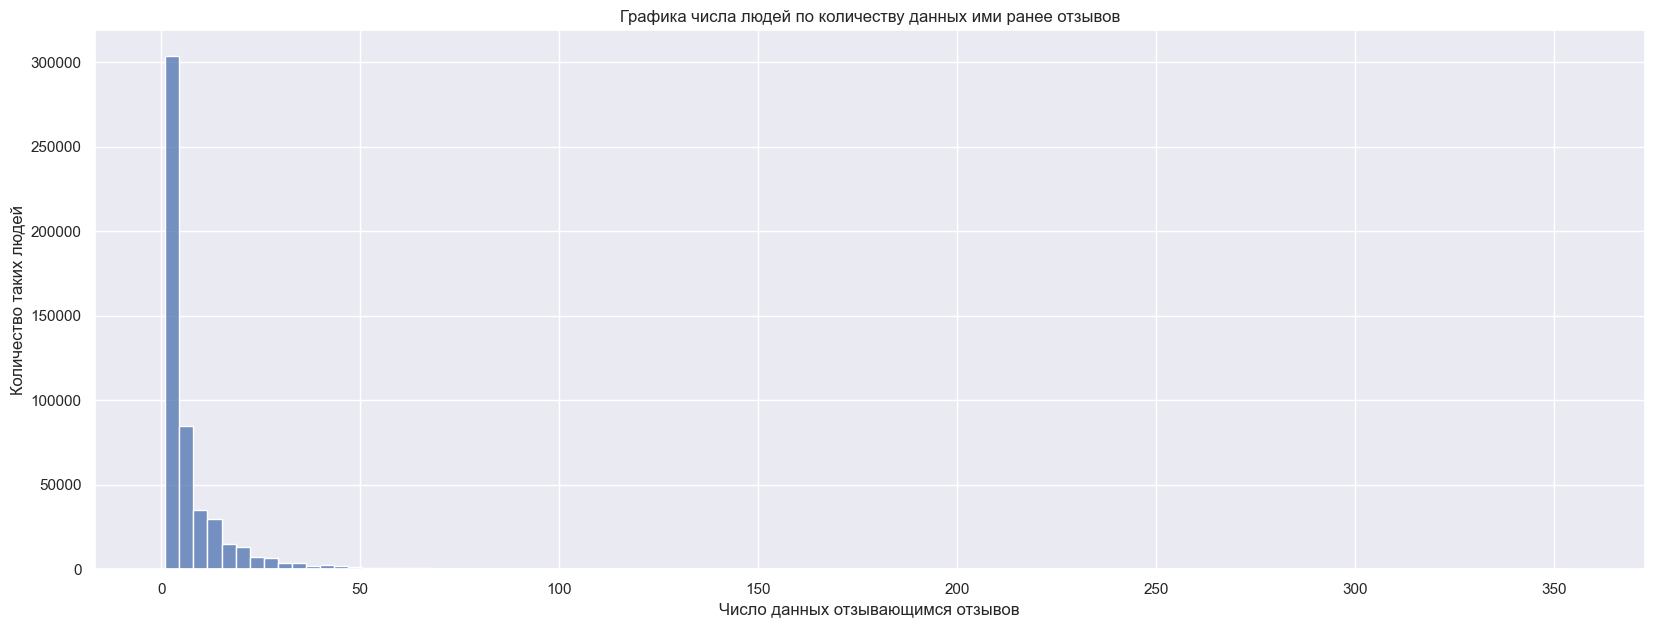

In [103]:
fig = plt.figure(figsize=(20, 7));
hist = sns.histplot(data = data, x = 'total_number_of_reviews_reviewer_has_given', bins=100);
hist.set_xlabel('Число данных отзывающимся отзывов');
hist.set_ylabel('Количество таких людей');
hist.set_title('Графика числа людей по количеству данных ими ранее отзывов');

In [104]:
data['total_number_of_reviews_reviewer_has_given'].describe()

count    515738.000000
mean          7.166001
std          11.040228
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

Стандартное отклонение: Существует значительное различие в количестве оставленных отзывов, с стандартным отклонением около 11.04, что указывает на широкий разброс данных.
Квартили:
25% рецензентов оставили только 1 отзыв, что может указывать на большое количество пользователей, которые пишут отзывы нечасто.
Медианное значение (50%) составляет 3 отзыва, что означает, что половина всех рецензентов оставила не более трех отзывов.
75% рецензентов оставили до 8 отзывов, подчеркивая, что большинство рецензентов имеют относительно небольшое количество отзывов.

## Признаки положительных/отрицательных отзывов

In [105]:
sent_analyzer = SentimentIntensityAnalyzer()
data['positive_compound'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
data['negative_compound'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [106]:
display(data[['positive_compound', 'positive_review', 'negative_compound', 'negative_review']].head())

,positive_compound,positive_review,negative_compound,negative_review
0,0.9615,Hotel was great clean friendly staff free bre...,-0.0554,Would have appreciated a shop in the hotel th...
1,0.3400,No Positive,-0.2960,No tissue paper box was present at the room
2,0.6908,Nice welcoming and service,0.0000,Pillows
3,0.9153,Everything including the nice upgrade The Hot...,-0.7096,No Negative
4,0.7717,Lovely hotel v welcoming staff,-0.7096,No Negative


In [107]:
data[['positive_compound',  'negative_compound']].describe()

,positive_compound,negative_compound
count,515738.000000,515738.000000
mean,0.593533,-0.209151
std,0.342460,0.453386
min,-0.983200,-0.998100
25%,0.350600,-0.709600
50%,0.708900,-0.177900
75%,0.883400,0.000000
max,0.999300,0.996400


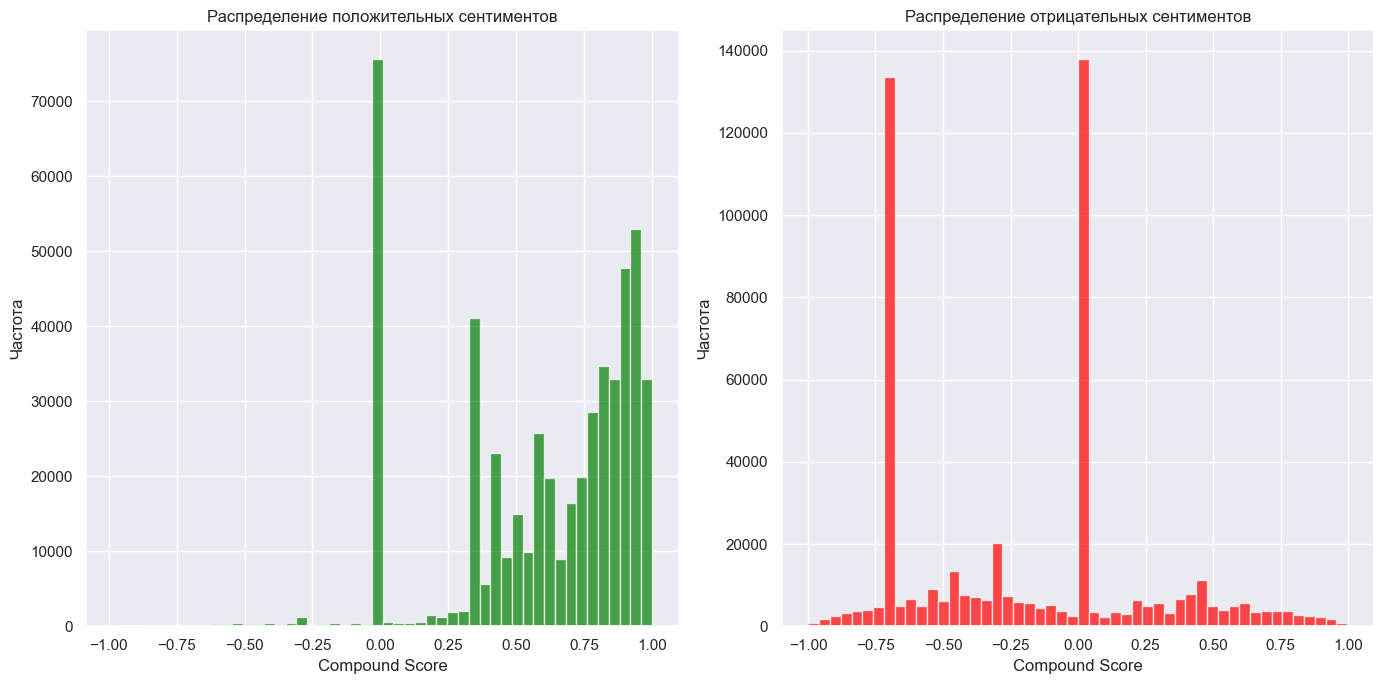

In [108]:
# Визуализация результатов
plt.figure(figsize=(14, 7))

# Гистограмма для положительных сентиментов
plt.subplot(1, 2, 1) # 1 строка, 2 колонки, первый график
plt.hist(data['positive_compound'], bins=50, color='green', alpha=0.7)
plt.title('Распределение положительных сентиментов')
plt.xlabel('Compound Score')
plt.ylabel('Частота')

# Гистограмма для отрицательных сентиментов
plt.subplot(1, 2, 2) # 1 строка, 2 колонки, второй график
plt.hist(data['negative_compound'], bins=50, color='red', alpha=0.7)
plt.title('Распределение отрицательных сентиментов')
plt.xlabel('Compound Score')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Сентимент отзывов: Положительные отзывы в среднем имеют высокий уровень положительности, в то время как отрицательные отзывы варьируются и включают как умеренно отрицательные, так и крайне отрицательные мнения.

# Кодирование категориальных данных

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [111]:
# Проведем OneHotEncoder для признака страна и город нахождения отеля.
encoder1 = ce.OneHotEncoder(cols=['country'])
country_bin = encoder1.fit_transform(data['country'])
data = pd.concat([data, country_bin], axis=1)

# Проведем OneHotEncoder для признака тип отдыха.
encoder1 = ce.OneHotEncoder(cols=['trip'])
trip_bin = encoder1.fit_transform(data['trip'])
data = pd.concat([data, trip_bin], axis=1)

# Проведем OneHotEncoder для признака страны рецензента .
encoder1 = ce.OneHotEncoder(cols=['nationality_category'])
nationality_category_bin = encoder1.fit_transform(data['nationality_category'])
data = pd.concat([data, nationality_category_bin], axis=1)



In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

# Отбор признаков

In [113]:
# Скопируем основной датафрейм для дальнейших манипуляций по отбору признаков.
df = data.copy()

In [114]:
# Уберем из датафрейма все категориальные признаки.
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [115]:
# Выведем информацию по нашему датасету.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   year_of_review                              515738 non-null  int64  
 

<Axes: >

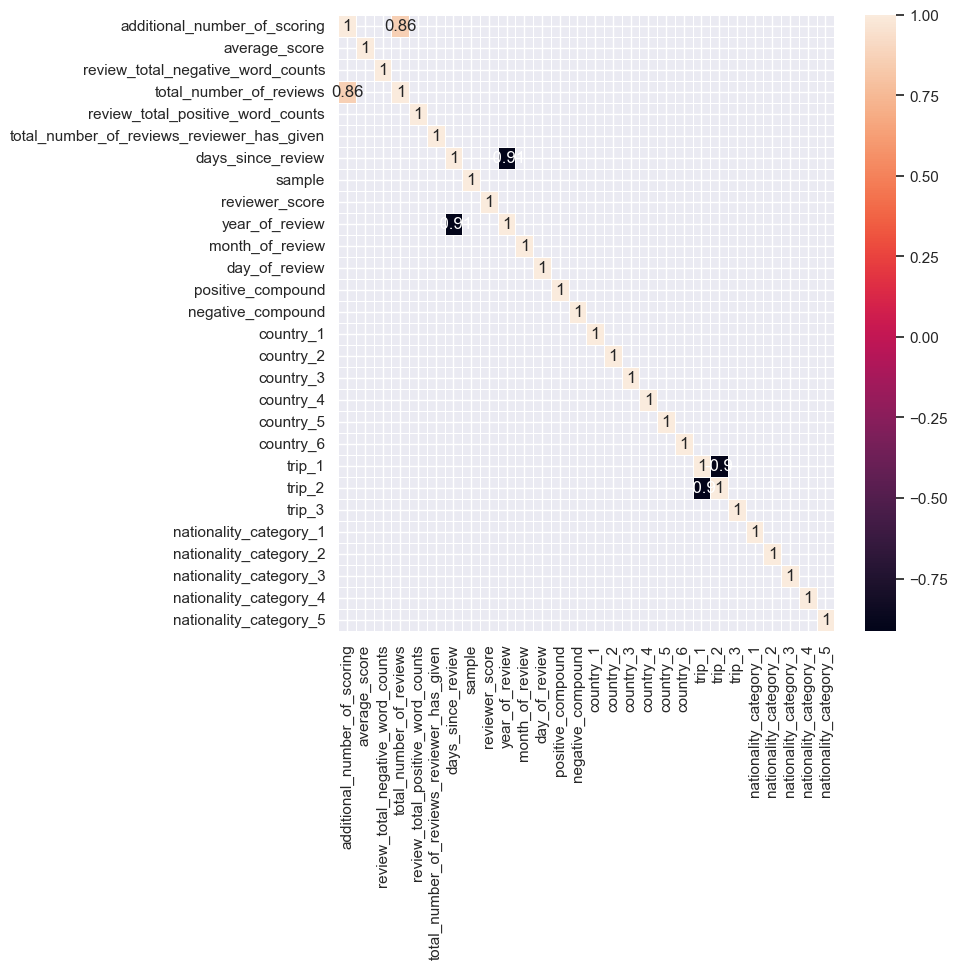

In [116]:
# Покажем корреляцию в виде тепловой карты.
sns.set()
fig, ax = plt.subplots(figsize=(8,8))
corr_df = df.corr(method='spearman')
# Отобразим корреляцию выше 80%.
sns.heatmap(corr_df[abs(corr_df) >= 0.8], annot=True, linewidths=.5, ax=ax)

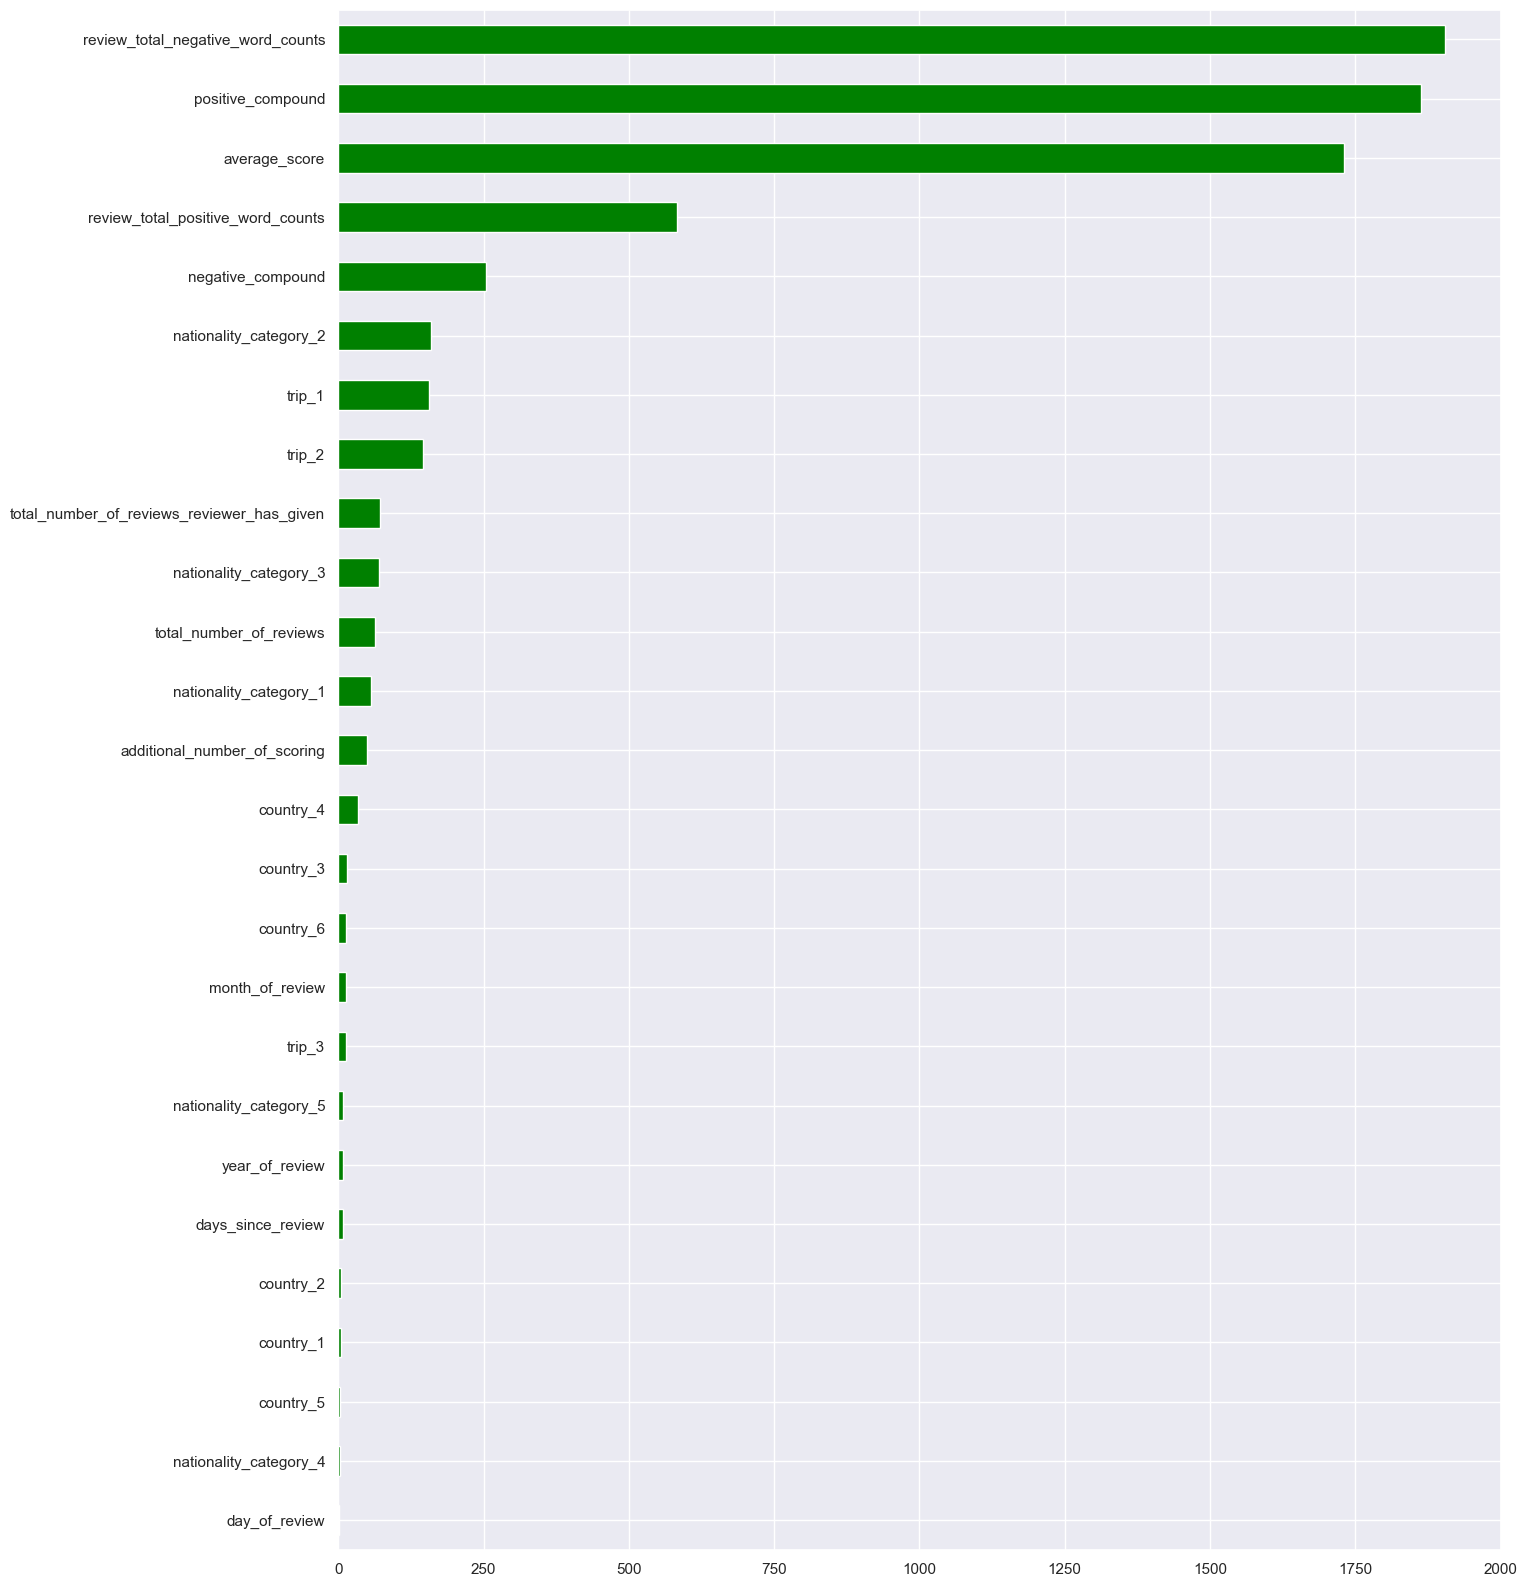

In [117]:
# Проведем оценку значимости признаков.
y = df.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = df.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# Визуализируем результат анализа значимости.
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

In [118]:
# Удалим некоторые признаки с высокой корреляцией.
df.drop(['additional_number_of_scoring', 'trip_2', 'days_since_review'], axis = 1, inplace=True)

# Обучение модели

In [119]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели.
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей).
y = train_data.reviewer_score.values 
X = train_data.drop(['reviewer_score'], axis=1)

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель.  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
      
# Обучаем модель на тестовом наборе данных.
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred.
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test).
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


MAPE: 0.1254234503989235


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [120]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1254234503989235


In [121]:
# Выполняем предсказание на тестовых данных.
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


In [122]:
# Сохраним полученные данные и сделаем сабмит.
sample_submission.to_csv('data\submission.csv', index=False)